# Introduction

This notebook is an introduction to the soil agent-based social network simulation framework.
In particular, we will focus on a specific use case: studying the propagation of news in a social network.

The steps we will follow are:

* Modelling the behavior of agents
* Running the simulation using different configurations
* Analysing the results of each simulation

But before that, let's import the soil module and networkx.

In [1]:
import soil
import networkx as nx

In [2]:
%pylab inline
# To display plots in the notebook

Populating the interactive namespace from numpy and matplotlib


# Basic concepts

There are three main elements in a soil simulation:
    
* The network topology. A simulation may use an existing NetworkX topology, or generate one on the fly
* Agents. There are two types: 1) network agents, which are linked to a node in the topology, and 2) environment agents, which are freely assigned to the environment.
* The environment. It assigns agents to nodes in the network, and stores the environment parameters (shared state for all agents).

Soil is based on ``simpy``, which is an event-based network simulation library.
Soil provides several abstractions over events to make developing agents easier.
This means you can use events (timeouts, delays) in soil, but for the most part we will assume your models will be step-based.


# Modeling behaviour

Our first step will be to model how every person in the social network reacts when it comes to news.
We will follow a very simple model (a finite state machine).

There are two types of people, those who have heard about a newsworthy event (infected) or those who have not (neutral).
A neutral person may heard about the news either on the TV (with probability **prob_tv_spread**) or through their friends.
Once a person has heard the news, they will spread it to their friends (with a probability **prob_neighbor_spread**).
Some users do not have a TV, so they only rely on their friends.

The spreading probabilities will change over time due to different factors.
We will represent this variance using an environment agent.

## Network Agents

A basic network agent in Soil should inherit from ``soil.agents.BaseAgent``, and define its behaviour in every step of the simulation by implementing a ``run(self)`` method.
The most important attributes of the agent are:

* ``agent.state``, a dictionary with the state of the agent. ``agent.state['id']`` reflects the state id of the agent. That state id can be used to look for other networks in that specific state. The state can be access via the agent as well. For instance:
```py
a = soil.agents.BaseAgent(env=env)
a['hours_of_sleep'] = 10
print(a['hours_of_sleep'])
```
  The state of the agent is stored in every step of the simulation:
  ```py
  print(a['hours_of_sleep', 10]) # hours of sleep before step #10
  print(a[None, 0]) # whole state of the agent before step #0
  ```

* ``agent.env``, a reference to the environment. Most commonly used to get access to the environment parameters and the topology:
    ```py
    a.env.G.nodes() # Get all nodes ids in the topology
    a.env['minimum_hours_of_sleep']

    ```

Since our model is a finite state machine, we will be basing it on ``soil.agents.FSM``.

With ``soil.agents.FSM``, we do not need to specify a ``step`` method.
Instead, we describe every step as a function.
To change to another state, a function may return the new state.
If no state is returned, the state remains unchanged.[
It will consist of two states, ``neutral`` (default) and ``infected``.

Here's the code:

In [3]:
import random

class NewsSpread(soil.agents.FSM):
    @soil.agents.default_state
    @soil.agents.state
    def neutral(self):
        r = random.random()
        if self['has_tv'] and r < self.env['prob_tv_spread']:
                return self.infected
        return
    
    @soil.agents.state
    def infected(self):
        prob_infect = self.env['prob_neighbor_spread']
        for neighbor in self.get_neighboring_agents(state_id=self.neutral.id):
            r = random.random()
            if r < prob_infect:
                neighbor.state['id'] = self.infected.id
        return
        

## Environment agents

Environment agents allow us to control the state of the environment.
In this case, we will use an environment agent to simulate a very viral event.

When the event happens, the agent will modify the probability of spreading the rumor.

In [4]:
NEIGHBOR_FACTOR = 0.9
TV_FACTOR = 0.5
class NewsEnvironmentAgent(soil.agents.BaseAgent):
    def step(self):
        if self.now == self['event_time']:
            self.env['prob_tv_spread'] = 1
            self.env['prob_neighbor_spread'] = 1
        elif self.now > self['event_time']:
            self.env['prob_tv_spread'] = self.env['prob_tv_spread'] * TV_FACTOR
            self.env['prob_neighbor_spread'] = self.env['prob_neighbor_spread'] * NEIGHBOR_FACTOR

## Testing the agents

Feel free to skip this section if this is your first time with soil.

Testing agents is not easy, and this is not a thorough testing process for agents.
Rather, this section is aimed to show you how to access internal pats of soil so you can test your agents.

First of all, let's check if our network agent has the states we would expect:

In [5]:
NewsSpread.states

{'infected': <function __main__.NewsSpread.infected>,
 'neutral': <function __main__.NewsSpread.neutral>}

Now, let's run a simulation on a simple network. It is comprised of three nodes:


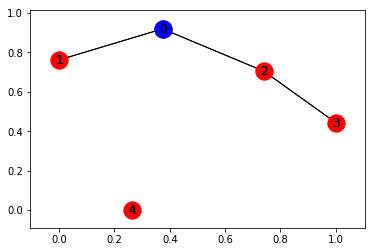

In [6]:
G = nx.Graph()
G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(2, 3)
G.add_node(4)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_color='red')
nx.draw_networkx(G, pos, nodelist=[0], node_color='blue')

Let's run a simple simulation that assigns a NewsSpread agent to all the nodes in that network.
Notice how node 0 is the only one with a TV.

In [7]:
env_params = {'prob_tv_spread': 0,
             'prob_neighbor_spread': 0}

MAX_TIME = 100
EVENT_TIME = 10

sim = soil.simulation.SoilSimulation(topology=G,
                                     num_trials=1,
                                     max_time=MAX_TIME,
                                     environment_agents=[{'agent_type': NewsEnvironmentAgent,
                                                         'state': {
                                                             'event_time': EVENT_TIME
                                                         }}],
                                     network_agents=[{'agent_type': NewsSpread,
                                                      'weight': 1}],
                                     states={0: {'has_tv': True}},
                                     default_state={'has_tv': False},
                                     environment_params=env_params)
env = sim.run_simulation()[0]

Trial: 0
	Running
Finished trial in 0.014928102493286133 seconds
Finished simulation in 0.015764951705932617 seconds


Now we can access the results of the simulation and compare them to our expected results

In [8]:
agents = list(env.network_agents)

# Until the event, all agents are neutral
for t in range(10):
    for a in agents:
        assert a['id', t] == a.neutral.id

# After the event, the node with a TV is infected, the rest are not
assert agents[0]['id', 11] == NewsSpread.infected.id

for a in agents[1:4]:
    assert a['id', 11] == NewsSpread.neutral.id

# At the end, the agents connected to the infected one will probably be infected, too.
assert agents[1]['id', MAX_TIME] == NewsSpread.infected.id
assert agents[2]['id', MAX_TIME] == NewsSpread.infected.id

# But the node with no friends should not be affected
assert agents[4]['id', MAX_TIME] == NewsSpread.neutral.id
        

Lastly, let's see if the probabilities have decreased as expected:

In [9]:
assert abs(env.environment_params['prob_neighbor_spread'] - (NEIGHBOR_FACTOR**(MAX_TIME-1-10))) < 10e-4
assert abs(env.environment_params['prob_tv_spread'] - (TV_FACTOR**(MAX_TIME-1-10))) < 10e-6

# Running the simulation

To run a simulation, we need a configuration.
Soil can load configurations from python dictionaries as well as JSON and YAML files.
For this demo, we will use a python dictionary:

In [10]:
config = {
    'name': 'ExampleSimulation',
    'max_time': 20,
    'interval': 1,
    'num_trials': 1,
    'network_params': {
       'generator': 'complete_graph',
        'n': 500,
    },
    'network_agents': [
        {
            'agent_type': NewsSpread,
            'weight': 1,
            'state': {
                'has_tv': False
            }
        },
        {
            'agent_type': NewsSpread,
            'weight': 2,
            'state': {
                'has_tv': True
            }
        }
    ],
    'states': [ {'has_tv': True} ],
    'environment_params':{
        'prob_tv_spread': 0.01,
        'prob_neighbor_spread': 0.5
    }
}

Let's run our simulation:

In [11]:
soil.simulation.run_from_config(config, dump=False)

Using config(s): ExampleSimulation
Trial: 0
	Running
Finished trial in 1.4140360355377197 seconds
Finished simulation in 2.4056642055511475 seconds


In real life, you probably want to run several simulations, varying some of the parameters so that you can compare and answer your research questions.

For instance:
    
* Does the outcome depend on the structure of our network? We will use different generation algorithms to compare them (Barabasi-Albert and Erdos-Renyi)
* How does neighbor spreading probability affect my simulation? We will try probability values in the range of [0, 0.4], in intervals of 0.1.

In [12]:
network_1 = {
       'generator': 'erdos_renyi_graph',
        'n': 500,
        'p': 0.1
}
network_2 = {
       'generator': 'barabasi_albert_graph',
        'n': 500,
        'm': 2
}


for net in [network_1, network_2]:
    for i in range(5):
        prob = i / 10
        config['environment_params']['prob_neighbor_spread'] = prob
        config['network_params'] = net
        config['name'] = 'Spread_{}_prob_{}'.format(net['generator'], prob)
        s = soil.simulation.run_from_config(config)

Using config(s): Spread_erdos_renyi_graph_prob_0.0
Trial: 0
	Running
Finished trial in 0.2691483497619629 seconds
Finished simulation in 0.3650345802307129 seconds
Using config(s): Spread_erdos_renyi_graph_prob_0.1
Trial: 0
	Running
Finished trial in 0.34261059761047363 seconds
Finished simulation in 0.44017767906188965 seconds
Using config(s): Spread_erdos_renyi_graph_prob_0.2
Trial: 0
	Running
Finished trial in 0.34417223930358887 seconds
Finished simulation in 0.4550771713256836 seconds
Using config(s): Spread_erdos_renyi_graph_prob_0.3
Trial: 0
	Running
Finished trial in 0.3237779140472412 seconds
Finished simulation in 0.42307496070861816 seconds
Using config(s): Spread_erdos_renyi_graph_prob_0.4
Trial: 0
	Running
Finished trial in 0.3507683277130127 seconds
Finished simulation in 0.45061564445495605 seconds
Using config(s): Spread_barabasi_albert_graph_prob_0.0
Trial: 0
	Running
Finished trial in 0.19115304946899414 seconds
Finished simulation in 0.20927715301513672 seconds
Using

The results are conveniently stored in pickle (simulation), csv (history of agent and environment state) and gexf format.

In [13]:
!tree soil_output
!du -xh soil_output/*

soil_output
├── Sim_prob_0
│   ├── Sim_prob_0.dumped.yml
│   ├── Sim_prob_0.simulation.pickle
│   ├── Sim_prob_0_trial_0.environment.csv
│   └── Sim_prob_0_trial_0.gexf
├── Spread_barabasi_albert_graph_prob_0.0
│   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml
│   ├── Spread_barabasi_albert_graph_prob_0.0.simulation.pickle
│   ├── Spread_barabasi_albert_graph_prob_0.0_trial_0.environment.csv
│   └── Spread_barabasi_albert_graph_prob_0.0_trial_0.gexf
├── Spread_barabasi_albert_graph_prob_0.1
│   ├── Spread_barabasi_albert_graph_prob_0.1.dumped.yml
│   ├── Spread_barabasi_albert_graph_prob_0.1.simulation.pickle
│   ├── Spread_barabasi_albert_graph_prob_0.1_trial_0.environment.csv
│   └── Spread_barabasi_albert_graph_prob_0.1_trial_0.gexf
├── Spread_barabasi_albert_graph_prob_0.2
│   ├── Spread_barabasi_albert_graph_prob_0.2.dumped.yml
│   ├── Spread_barabasi_albert_graph_prob_0.2.simulation.pickle
│   ├── Spread_barabasi_albert_graph_prob_0.2_trial_0.environment.csv
│   └── Spread

# Analysing the results

Once the simulations are over, we can use soil to analyse the results.

First, let's load the stored results into a pandas dataframe.

In [14]:
%pylab inline
from soil import analysis

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
config_file, df, config  = list(analysis.get_data('soil_output/Spread_barabasi*prob_0.1*', process=False))[0]
df

,agent_id,tstep,attribute,value
0,env,0,prob_tv_spread,0.01
1,env,0,prob_neighbor_spread,0.1
2,env,1,prob_tv_spread,0.01
3,env,1,prob_neighbor_spread,0.1
4,env,2,prob_tv_spread,0.01
5,env,2,prob_neighbor_spread,0.1
6,env,3,prob_tv_spread,0.01
7,env,3,prob_neighbor_spread,0.1
8,env,4,prob_tv_spread,0.01
9,env,4,prob_neighbor_spread,0.1


In [16]:
list(analysis.get_data('soil_output/Spread_barabasi*prob_0.1*', process=True))[0][1]

value,0.01,0.1,False,True,infected,neutral
tstep,,,,,,
0,1.0,1.0,163.0,337.0,0.0,500.0
1,1.0,1.0,163.0,337.0,3.0,497.0
2,1.0,1.0,163.0,337.0,6.0,494.0
3,1.0,1.0,163.0,337.0,12.0,488.0
4,1.0,1.0,163.0,337.0,23.0,477.0
5,1.0,1.0,163.0,337.0,36.0,464.0
6,1.0,1.0,163.0,337.0,53.0,447.0
7,1.0,1.0,163.0,337.0,79.0,421.0
8,1.0,1.0,163.0,337.0,119.0,381.0


If you don't want to work with pandas, you can also use some pre-defined functions from soil to conveniently plot the results:

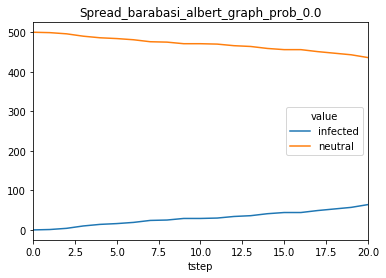

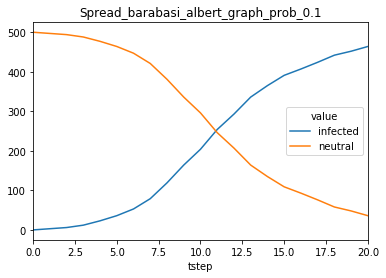

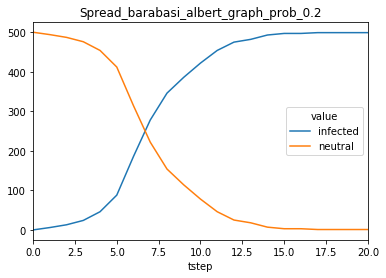

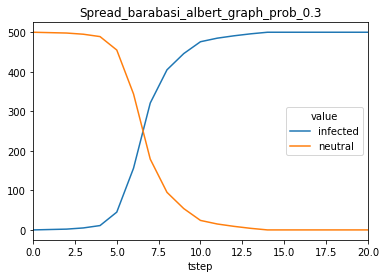

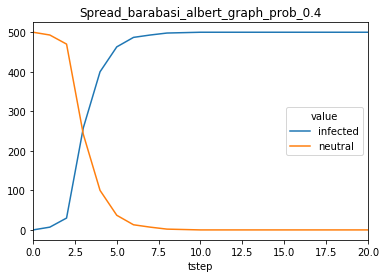

In [17]:
analysis.plot_all('soil_output/Spread_barabasi*', attributes=['id'])

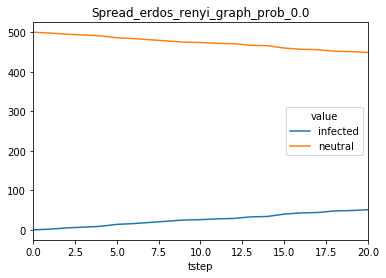

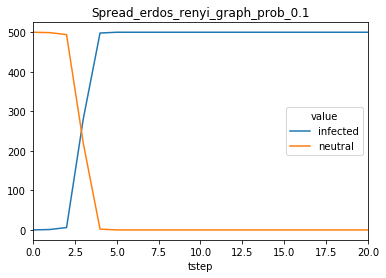

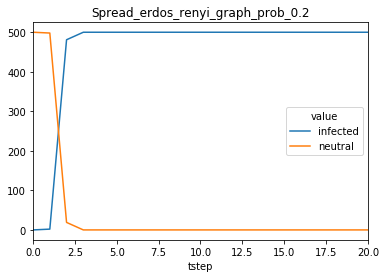

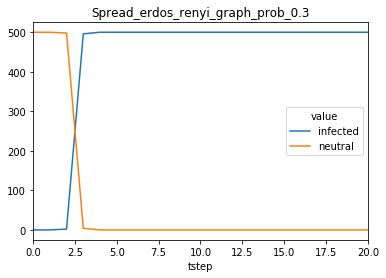

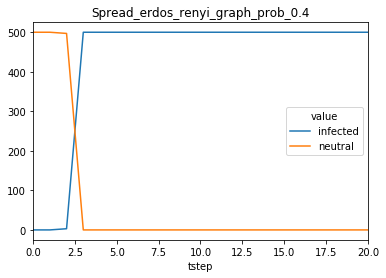

In [18]:
analysis.plot_all('soil_output/Spread_erdos*', attributes=['id'])